In [2]:
import random
import datetime
import pandas as pd
import numpy as np
from haversine import haversine
import folium
from datetime import datetime
import time
from tqdm import tqdm
import gc
import geopy.distance
import seaborn as sns
import shap
import matplotlib.pyplot as plt

## Data Loading

In [3]:
df1 = pd.read_csv("data/gps_fulldata_20220512_20220819.csv", encoding='shift_jis', usecols=[0,1,2,4,6])
df2 = pd.read_csv("data/gps_20220820_20221107.csv", encoding='shift_jis', header=None, usecols=[0,1,2,4,6], names=df1.columns)


In [4]:
df = pd.concat([df1, df2],axis=0)
df.sort_values(by=['vehicleCode', 'timestamp'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,vehicleCode,lat,lng,timestamp,distance
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186
...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303


In [5]:
del [[df1, df2]]
gc.collect()
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33839775 entries, 0 to 33839774
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   vehicleCode  object 
 1   lat          float64
 2   lng          float64
 3   timestamp    object 
 4   distance     float64
dtypes: float64(3), object(2)
memory usage: 1.3+ GB


In [7]:
target_df = df.copy()

## Data preprocessing

In [8]:
lng_margin = [130.8754025956282,143.49215552451497]
lat_margin = [31.939262095093653,39.08345291592023]

def check_outlier(value):
    lat, lng = map(float, value.split())
    if ((lng<lng_margin[0]) | (lng>lng_margin[1])|(lat<lat_margin[0]) | (lat>lat_margin[1])):
        return 1
    else :
        return 0

In [9]:
target_df['coord'] = target_df['lat'].map(str)+' '+target_df['lng'].map(str)
target_df

,vehicleCode,lat,lng,timestamp,distance,coord
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000,35.081511 136.931423
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071,35.08182 136.931295
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148,35.081825 136.93128
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548,35.081957 136.931339
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186,35.082085 136.931459
...,...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708,35.501584 139.439746
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719,35.501576 139.439728
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742,35.50151 139.439645
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303,35.501472 139.439588


In [10]:
#delete outlier

target_df['is_outlier'] = target_df['coord'].apply(lambda x : check_outlier(x))

In [11]:
target_df['is_outlier'].value_counts()

0    33835568
1        4207
Name: is_outlier, dtype: int64

In [12]:
target_df.drop(target_df[target_df['is_outlier']==1].index, inplace = True)
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier
0,W1,35.081511,136.931423,2022-05-12T06:41:13+09:00,0.000000,35.081511 136.931423,0
1,W1,35.081820,136.931295,2022-05-12T06:49:47+09:00,36.214071,35.08182 136.931295,0
2,W1,35.081825,136.931280,2022-05-12T06:50:34+09:00,1.476148,35.081825 136.93128,0
3,W1,35.081957,136.931339,2022-05-12T06:50:39+09:00,15.601548,35.081957 136.931339,0
4,W1,35.082085,136.931459,2022-05-12T06:50:44+09:00,17.928186,35.082085 136.931459,0
...,...,...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04T16:55:42+09:00,4.121708,35.501584 139.439746,0
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04T16:55:48+09:00,1.858719,35.501576 139.439728,0
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04T16:55:53+09:00,10.503742,35.50151 139.439645,0
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04T16:55:58+09:00,6.672303,35.501472 139.439588,0


In [13]:
import datetime
target_df['timestamp']=target_df['timestamp'].apply(lambda x: datetime.datetime.strptime(x[:-6], '%Y-%m-%dt%H:%M:%S'))

serials = target_df['vehicleCode'].unique()
for serial in serials:
    target_df.loc[target_df.vehicleCode==serial, 'del_time'] = \
    np.append(0, (target_df.loc[target_df.vehicleCode==serial, 'timestamp'][1:].reset_index(drop=True)-target_df.loc[target_df.vehicleCode==serial, 'timestamp'][:-1].reset_index(drop=True)).apply(lambda x: x.seconds).values)

In [14]:
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time
0,W1,35.081511,136.931423,2022-05-12 06:41:13,0.000000,35.081511 136.931423,0,0.0
1,W1,35.081820,136.931295,2022-05-12 06:49:47,36.214071,35.08182 136.931295,0,514.0
2,W1,35.081825,136.931280,2022-05-12 06:50:34,1.476148,35.081825 136.93128,0,47.0
3,W1,35.081957,136.931339,2022-05-12 06:50:39,15.601548,35.081957 136.931339,0,5.0
4,W1,35.082085,136.931459,2022-05-12 06:50:44,17.928186,35.082085 136.931459,0,5.0
...,...,...,...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04 16:55:42,4.121708,35.501584 139.439746,0,5.0
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04 16:55:48,1.858719,35.501576 139.439728,0,6.0
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04 16:55:53,10.503742,35.50151 139.439645,0,5.0
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04 16:55:58,6.672303,35.501472 139.439588,0,5.0


In [15]:
# more than 3 hours -> new course
vehicleCodes=target_df['vehicleCode'].unique()
idx = list(target_df[target_df['del_time']>3*60*60].index)

for i in vehicleCodes:
    idx.append(target_df[target_df['vehicleCode']==i].index[0])
    
idx=sorted(list(set(idx)))

target_df.loc[0, 'course'] = 0
target_df.loc[idx, 'course'] = np.arange(1, len(idx)+1)
target_df['course'].fillna(method='ffill', inplace=True)

In [16]:
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course
0,W1,35.081511,136.931423,2022-05-12 06:41:13,0.000000,35.081511 136.931423,0,0.0,1.0
1,W1,35.081820,136.931295,2022-05-12 06:49:47,36.214071,35.08182 136.931295,0,514.0,1.0
2,W1,35.081825,136.931280,2022-05-12 06:50:34,1.476148,35.081825 136.93128,0,47.0,1.0
3,W1,35.081957,136.931339,2022-05-12 06:50:39,15.601548,35.081957 136.931339,0,5.0,1.0
4,W1,35.082085,136.931459,2022-05-12 06:50:44,17.928186,35.082085 136.931459,0,5.0,1.0
...,...,...,...,...,...,...,...,...,...
33839770,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04 16:55:42,4.121708,35.501584 139.439746,0,5.0,10813.0
33839771,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04 16:55:48,1.858719,35.501576 139.439728,0,6.0,10813.0
33839772,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04 16:55:53,10.503742,35.50151 139.439645,0,5.0,10813.0
33839773,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04 16:55:58,6.672303,35.501472 139.439588,0,5.0,10813.0


In [17]:
target_place = {}
target_place[1] = (35.50116466410529, 139.7705922117356) #"Higashi-Ogishima"
target_place[2] = (35.55769134902504, 139.66477025889324) #"K1"
target_place[3] = (35.47115639628905, 139.36695126985464) #"Atsugi"
target_place[4] = (35.520388068094086, 139.3521451687072) #"Nakatsu"

def get_gps_distance(location, radi):
    for i in target_place.keys():
        if(haversine(location, target_place[i]) < radi):
            return i
    return 0

radi = 0.3 # 300m
target_df['location'] = target_df[['lat','lng']].apply(lambda x : get_gps_distance(tuple(x.values), radi), axis=1)
target_df.head()

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location
0,W1,35.081511,136.931423,2022-05-12 06:41:13,0.000000,35.081511 136.931423,0,0.0,1.0,0
1,W1,35.081820,136.931295,2022-05-12 06:49:47,36.214071,35.08182 136.931295,0,514.0,1.0,0
2,W1,35.081825,136.931280,2022-05-12 06:50:34,1.476148,35.081825 136.93128,0,47.0,1.0,0
3,W1,35.081957,136.931339,2022-05-12 06:50:39,15.601548,35.081957 136.931339,0,5.0,1.0,0
4,W1,35.082085,136.931459,2022-05-12 06:50:44,17.928186,35.082085 136.931459,0,5.0,1.0,0


In [21]:
target_df.reset_index(inplace=True, drop=True)
target_df

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location
0,W1,35.081511,136.931423,2022-05-12 06:41:13,0.000000,35.081511 136.931423,0,0.0,1.0,0
1,W1,35.081820,136.931295,2022-05-12 06:49:47,36.214071,35.08182 136.931295,0,514.0,1.0,0
2,W1,35.081825,136.931280,2022-05-12 06:50:34,1.476148,35.081825 136.93128,0,47.0,1.0,0
3,W1,35.081957,136.931339,2022-05-12 06:50:39,15.601548,35.081957 136.931339,0,5.0,1.0,0
4,W1,35.082085,136.931459,2022-05-12 06:50:44,17.928186,35.082085 136.931459,0,5.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
33835563,座間エンジン（3時区）-2,35.501584,139.439746,2022-11-04 16:55:42,4.121708,35.501584 139.439746,0,5.0,10813.0,0
33835564,座間エンジン（3時区）-2,35.501576,139.439728,2022-11-04 16:55:48,1.858719,35.501576 139.439728,0,6.0,10813.0,0
33835565,座間エンジン（3時区）-2,35.501510,139.439645,2022-11-04 16:55:53,10.503742,35.50151 139.439645,0,5.0,10813.0,0
33835566,座間エンジン（3時区）-2,35.501472,139.439588,2022-11-04 16:55:58,6.672303,35.501472 139.439588,0,5.0,10813.0,0


In [18]:
Higashi_pass= list(target_df[target_df['location']==1]['course'].unique())
K1_pass= list(target_df[target_df['location']==2]['course'].unique())
Atsugi_pass= list(target_df[target_df['location']==3]['course'].unique())
Nakatsu_pass= list(target_df[target_df['location']==4]['course'].unique())

print("Higashi_count = {}\nK1_count = {}\nAtsugi_count = {}\nNakatsu_count = {}".format(len(Higashi_pass),len(K1_pass),len(Atsugi_pass),len(Nakatsu_pass)))

Higashi_count = 1472
K1_count = 4904
Atsugi_count = 1964
Nakatsu_count = 1653


In [22]:
#Higashi_pass
Higashi_data_index = []
for drive in Higashi_pass:
    temp =target_df[target_df['course']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==1]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==1):
        end = temp.iloc[9].name
        Higashi_data_index.extend([x for x in range(start,end)])

In [ ]:
#K1pass
K1_data_index = []
for drive in K1_pass:
    temp =target_df[target_df['course']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==2]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==2):
        end = temp.iloc[9].name
        K1_data_index.extend([x for x in range(start,end)])

In [ ]:
#Atsugi pass
Atsugi_data_index =[]
for drive in K1_pass:
    temp =target_df[target_df['course']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==3]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==3):
        end = temp.iloc[9].name
        Atsugi_data_index.extend([x for x in range(start, end)])

In [ ]:
#Nakatsu pass
Nakatsu_data_index = []
for drive in K1_pass:
    temp =target_df[target_df['course']==drive]
    start = temp.index[0]
    temp = temp[temp['location']==2]
    if(len(temp)<10):
        continue 
    if(temp.iloc[9].location==2):
        end = temp.iloc[9].name
        Nakatsu_data_index.extend([x for x in range(start, end)])

In [23]:
Higashi_data = target_df.loc[Higashi_data_index]
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0
...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1


In [26]:
ata_dic= Higashi_data.groupby("course")['timestamp'].max()
ata_dic

course
319.0     2022-07-23 20:07:40
702.0     2022-07-08 12:16:01
709.0     2022-07-15 12:43:31
712.0     2022-07-18 06:12:06
726.0     2022-08-03 05:39:09
                  ...        
9672.0    2022-11-01 03:28:38
9673.0    2022-11-02 03:30:26
9674.0    2022-11-03 03:28:45
9675.0    2022-11-04 03:28:41
10747.0   2022-07-22 12:15:15
Name: timestamp, Length: 1464, dtype: datetime64[ns]

In [29]:
Higashi_data['ata'] = Higashi_data['course'].apply(lambda x: ata_dic[x])
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40
...,...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15


In [30]:
Higashi_data['left_time'] = Higashi_data['ata'] - Higashi_data['timestamp']
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata,left_time
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40,0 days 00:46:30
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40,0 days 00:46:12
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40,0 days 00:43:08
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40,0 days 00:41:59
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40,0 days 00:41:54
...,...,...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0 days 00:00:20
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0 days 00:00:15
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0 days 00:00:10
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0 days 00:00:05


In [39]:
Higashi_data['left_time']= Higashi_data['left_time'].apply(lambda x : x.total_seconds()//60)
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata,left_time
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40,2790.0
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40,2772.0
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40,2588.0
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40,2519.0
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40,2514.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,20.0
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,15.0
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,10.0
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,5.0


In [41]:
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata,left_time
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40,46.0
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40,46.0
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40,43.0
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40,41.0
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0


In [48]:
def get_left_distance(Truck_GPS, target_place):
    return haversine(Truck_GPS, target_place)

Higashi_data['distance_btw_target'] = Higashi_data['coord'].apply(lambda x : get_left_distance(map(float,tuple(x.split())),target_place[1]))
Higashi_data.head()

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata,left_time,distance_btw_target
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40,46.0,11.383252
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40,46.0,11.385259
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40,43.0,11.387738
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40,41.0,11.389791
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40,41.0,11.376077


In [49]:
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata,left_time,distance_btw_target
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40,46.0,11.383252
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40,46.0,11.385259
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40,43.0,11.387738
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40,41.0,11.389791
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40,41.0,11.376077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941


In [58]:
Higashi_data['weekday'] = Higashi_data['timestamp'].dt.weekday
Higashi_data

,vehicleCode,lat,lng,timestamp,distance,coord,is_outlier,del_time,course,location,ata,left_time,distance_btw_target,weekday
945272,W103,35.535788,139.652229,2022-07-23 19:21:10,0.000000,35.535788 139.652229,0,15659.0,319.0,0,2022-07-23 20:07:40,46.0,11.383252,5
945273,W103,35.535898,139.652254,2022-07-23 19:21:28,12.413350,35.535898 139.652254,0,18.0,319.0,0,2022-07-23 20:07:40,46.0,11.385259,5
945274,W103,35.535896,139.652224,2022-07-23 19:24:32,2.729704,35.535896 139.652224,0,184.0,319.0,0,2022-07-23 20:07:40,43.0,11.387738,5
945275,W103,35.535955,139.652226,2022-07-23 19:25:41,6.548587,35.535955 139.652226,0,69.0,319.0,0,2022-07-23 20:07:40,41.0,11.389791,5
945276,W103,35.535966,139.652392,2022-07-23 19:25:46,15.103753,35.535966 139.652392,0,5.0,319.0,0,2022-07-23 20:07:40,41.0,11.376077,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:14:55,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941,4
33643436,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:00,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941,4
33643437,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:05,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941,4
33643438,座間エンジン（3時区）-2,35.503359,139.769776,2022-07-22 12:15:10,0.000000,35.503359 139.769776,0,5.0,10747.0,1,2022-07-22 12:15:15,0.0,0.254941,4


In [50]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [59]:
y = Higashi_data['left_time']
X = Higashi_data.drop(['left_time','timestamp','coord','del_time','is_outlier','ata','course','location'],axis=1)
X

,vehicleCode,lat,lng,distance,distance_btw_target,weekday
945272,W103,35.535788,139.652229,0.000000,11.383252,5
945273,W103,35.535898,139.652254,12.413350,11.385259,5
945274,W103,35.535896,139.652224,2.729704,11.387738,5
945275,W103,35.535955,139.652226,6.548587,11.389791,5
945276,W103,35.535966,139.652392,15.103753,11.376077,5
...,...,...,...,...,...,...
33643435,座間エンジン（3時区）-2,35.503359,139.769776,0.000000,0.254941,4
33643436,座間エンジン（3時区）-2,35.503359,139.769776,0.000000,0.254941,4
33643437,座間エンジン（3時区）-2,35.503359,139.769776,0.000000,0.254941,4
33643438,座間エンジン（3時区）-2,35.503359,139.769776,0.000000,0.254941,4


In [90]:
x_train, x_test , y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 1422)
x_train

,vehicleCode,lat,lng,distance,distance_btw_target,weekday
18547251,W47-2,34.849883,134.804429,146.870725,457.094245,0
20949408,W52,35.490997,139.671103,63.036779,9.077446,1
21211371,W53,35.449593,139.670768,67.707420,10.704941,2
18786189,W47-3,35.537574,139.699474,63.733602,7.603867,3
16444447,W45-2,35.051909,136.799782,118.249758,274.256761,3
...,...,...,...,...,...,...
2522851,W109,35.520519,139.366776,49.975552,36.614064,1
14319350,W44-1,34.677626,133.761929,34.953581,554.227604,1
14410282,W44-2,35.137295,138.514582,110.117255,120.924940,1
2754946,W109,35.516314,139.481961,11.980644,26.179924,2


In [61]:

seed =1422
model1= CatBoostRegressor(
                          eval_metric = 'RMSE',
                          cat_features = ['vehicleCode','weekday'],
                          random_state=seed,
                         verbose = True)

model1.fit(x_train , y_train)

Learning rate set to 0.141967
0:	learn: 299.2693294	total: 1.23s	remaining: 20m 32s
1:	learn: 286.1144712	total: 1.96s	remaining: 16m 15s
2:	learn: 275.9432836	total: 2.55s	remaining: 14m 7s
3:	learn: 268.1356028	total: 3.08s	remaining: 12m 46s
4:	learn: 261.6382251	total: 3.67s	remaining: 12m 9s
5:	learn: 256.3476312	total: 4.18s	remaining: 11m 32s
6:	learn: 251.1799705	total: 4.68s	remaining: 11m 3s
7:	learn: 247.1901891	total: 5.73s	remaining: 11m 50s
8:	learn: 244.0945286	total: 6.88s	remaining: 12m 37s
9:	learn: 240.3086660	total: 7.73s	remaining: 12m 45s
10:	learn: 238.4864368	total: 9.12s	remaining: 13m 40s
11:	learn: 236.5724887	total: 10.1s	remaining: 13m 50s
12:	learn: 233.3853537	total: 10.6s	remaining: 13m 27s
13:	learn: 231.6296075	total: 11.2s	remaining: 13m 5s
14:	learn: 228.5068353	total: 11.5s	remaining: 12m 33s
15:	learn: 225.0833767	total: 11.8s	remaining: 12m 5s
16:	learn: 223.7883625	total: 12.2s	remaining: 11m 47s
17:	learn: 223.2092386	total: 12.6s	remaining: 11m

151:	learn: 189.4122405	total: 1m 22s	remaining: 7m 42s
152:	learn: 189.1524103	total: 1m 23s	remaining: 7m 40s
153:	learn: 189.0614949	total: 1m 23s	remaining: 7m 40s
154:	learn: 189.0253226	total: 1m 24s	remaining: 7m 39s
155:	learn: 188.9875745	total: 1m 24s	remaining: 7m 37s
156:	learn: 188.9637114	total: 1m 25s	remaining: 7m 36s
157:	learn: 188.9450533	total: 1m 25s	remaining: 7m 36s
158:	learn: 188.9126946	total: 1m 26s	remaining: 7m 35s
159:	learn: 188.8831478	total: 1m 26s	remaining: 7m 34s
160:	learn: 188.8695277	total: 1m 26s	remaining: 7m 32s
161:	learn: 188.7592731	total: 1m 27s	remaining: 7m 32s
162:	learn: 188.7310173	total: 1m 27s	remaining: 7m 30s
163:	learn: 188.6755269	total: 1m 28s	remaining: 7m 29s
164:	learn: 188.6448644	total: 1m 28s	remaining: 7m 28s
165:	learn: 188.4571899	total: 1m 28s	remaining: 7m 27s
166:	learn: 188.4477333	total: 1m 29s	remaining: 7m 26s
167:	learn: 188.4332485	total: 1m 30s	remaining: 7m 25s
168:	learn: 188.4068779	total: 1m 30s	remaining:

299:	learn: 184.5772110	total: 2m 26s	remaining: 5m 42s
300:	learn: 184.5528534	total: 2m 27s	remaining: 5m 41s
301:	learn: 184.5482499	total: 2m 27s	remaining: 5m 40s
302:	learn: 184.5375440	total: 2m 27s	remaining: 5m 40s
303:	learn: 184.5362554	total: 2m 28s	remaining: 5m 39s
304:	learn: 184.5265427	total: 2m 28s	remaining: 5m 39s
305:	learn: 184.5186375	total: 2m 29s	remaining: 5m 38s
306:	learn: 184.5120393	total: 2m 29s	remaining: 5m 38s
307:	learn: 184.4978146	total: 2m 30s	remaining: 5m 37s
308:	learn: 184.4918083	total: 2m 30s	remaining: 5m 36s
309:	learn: 184.4665430	total: 2m 30s	remaining: 5m 35s
310:	learn: 184.4144201	total: 2m 31s	remaining: 5m 35s
311:	learn: 184.4072933	total: 2m 31s	remaining: 5m 35s
312:	learn: 184.3885897	total: 2m 32s	remaining: 5m 34s
313:	learn: 184.3541575	total: 2m 32s	remaining: 5m 34s
314:	learn: 184.3054856	total: 2m 33s	remaining: 5m 33s
315:	learn: 184.2831728	total: 2m 33s	remaining: 5m 32s
316:	learn: 184.2668193	total: 2m 34s	remaining:

447:	learn: 182.5035377	total: 3m 32s	remaining: 4m 22s
448:	learn: 182.4980813	total: 3m 33s	remaining: 4m 21s
449:	learn: 182.4938887	total: 3m 33s	remaining: 4m 21s
450:	learn: 182.4772935	total: 3m 34s	remaining: 4m 20s
451:	learn: 182.4772696	total: 3m 34s	remaining: 4m 19s
452:	learn: 182.4634230	total: 3m 34s	remaining: 4m 19s
453:	learn: 182.4564564	total: 3m 35s	remaining: 4m 19s
454:	learn: 182.4517182	total: 3m 35s	remaining: 4m 18s
455:	learn: 182.4364443	total: 3m 36s	remaining: 4m 18s
456:	learn: 182.4209329	total: 3m 36s	remaining: 4m 17s
457:	learn: 182.4151261	total: 3m 37s	remaining: 4m 16s
458:	learn: 182.4029014	total: 3m 37s	remaining: 4m 16s
459:	learn: 182.3991097	total: 3m 38s	remaining: 4m 15s
460:	learn: 182.3867335	total: 3m 38s	remaining: 4m 15s
461:	learn: 182.3843461	total: 3m 39s	remaining: 4m 15s
462:	learn: 182.3556443	total: 3m 39s	remaining: 4m 14s
463:	learn: 182.3489923	total: 3m 39s	remaining: 4m 13s
464:	learn: 182.3439422	total: 3m 40s	remaining:

595:	learn: 181.3967211	total: 4m 40s	remaining: 3m 10s
596:	learn: 181.3890151	total: 4m 41s	remaining: 3m 9s
597:	learn: 181.3824929	total: 4m 41s	remaining: 3m 9s
598:	learn: 181.3762110	total: 4m 41s	remaining: 3m 8s
599:	learn: 181.3735714	total: 4m 42s	remaining: 3m 8s
600:	learn: 181.3635936	total: 4m 42s	remaining: 3m 7s
601:	learn: 181.3626864	total: 4m 43s	remaining: 3m 7s
602:	learn: 181.3583042	total: 4m 43s	remaining: 3m 6s
603:	learn: 181.3353294	total: 4m 44s	remaining: 3m 6s
604:	learn: 181.3311247	total: 4m 44s	remaining: 3m 6s
605:	learn: 181.3288719	total: 4m 45s	remaining: 3m 5s
606:	learn: 181.3191990	total: 4m 45s	remaining: 3m 5s
607:	learn: 181.3155982	total: 4m 46s	remaining: 3m 4s
608:	learn: 181.3131105	total: 4m 46s	remaining: 3m 4s
609:	learn: 181.2983150	total: 4m 47s	remaining: 3m 3s
610:	learn: 181.2903201	total: 4m 47s	remaining: 3m 3s
611:	learn: 181.2871668	total: 4m 48s	remaining: 3m 2s
612:	learn: 181.2821352	total: 4m 48s	remaining: 3m 2s
613:	lear

743:	learn: 180.4248385	total: 5m 50s	remaining: 2m
744:	learn: 180.4235779	total: 5m 51s	remaining: 2m
745:	learn: 180.4199703	total: 5m 51s	remaining: 1m 59s
746:	learn: 180.4108327	total: 5m 52s	remaining: 1m 59s
747:	learn: 180.4076830	total: 5m 53s	remaining: 1m 58s
748:	learn: 180.4053102	total: 5m 53s	remaining: 1m 58s
749:	learn: 180.4034859	total: 5m 53s	remaining: 1m 57s
750:	learn: 180.3974044	total: 5m 54s	remaining: 1m 57s
751:	learn: 180.3914502	total: 5m 54s	remaining: 1m 57s
752:	learn: 180.3762564	total: 5m 55s	remaining: 1m 56s
753:	learn: 180.3758613	total: 5m 56s	remaining: 1m 56s
754:	learn: 180.3582371	total: 5m 56s	remaining: 1m 55s
755:	learn: 180.3582193	total: 5m 57s	remaining: 1m 55s
756:	learn: 180.3561060	total: 5m 57s	remaining: 1m 54s
757:	learn: 180.3518563	total: 5m 58s	remaining: 1m 54s
758:	learn: 180.3474840	total: 5m 58s	remaining: 1m 53s
759:	learn: 180.3474430	total: 5m 59s	remaining: 1m 53s
760:	learn: 180.3473676	total: 5m 59s	remaining: 1m 52s


892:	learn: 179.6952734	total: 7m 5s	remaining: 51s
893:	learn: 179.6916313	total: 7m 5s	remaining: 50.5s
894:	learn: 179.6908408	total: 7m 6s	remaining: 50s
895:	learn: 179.6837806	total: 7m 6s	remaining: 49.5s
896:	learn: 179.6811461	total: 7m 7s	remaining: 49s
897:	learn: 179.6775242	total: 7m 7s	remaining: 48.5s
898:	learn: 179.6743804	total: 7m 7s	remaining: 48.1s
899:	learn: 179.6741930	total: 7m 8s	remaining: 47.6s
900:	learn: 179.6740604	total: 7m 8s	remaining: 47.1s
901:	learn: 179.6740081	total: 7m 9s	remaining: 46.6s
902:	learn: 179.6706345	total: 7m 9s	remaining: 46.2s
903:	learn: 179.6704116	total: 7m 10s	remaining: 45.7s
904:	learn: 179.6675169	total: 7m 11s	remaining: 45.2s
905:	learn: 179.6654998	total: 7m 11s	remaining: 44.8s
906:	learn: 179.6604383	total: 7m 12s	remaining: 44.3s
907:	learn: 179.6529407	total: 7m 12s	remaining: 43.9s
908:	learn: 179.6472923	total: 7m 13s	remaining: 43.4s
909:	learn: 179.6472179	total: 7m 13s	remaining: 42.9s
910:	learn: 179.6293534	tot

In [70]:
# check the performance

from sklearn.metrics import mean_squared_error, r2_score
pred = model1.predict(x_test)
mse = mean_squared_error(y_test , pred)
r2 = r2_score(y_test, pred)
print(f'rmse : {np.sqrt(mse)}')
print(f'r2 : {r2}')

rmse : 178.84817163825898
r2 : 0.6804084326016664


In [71]:
test_df = x_test
test_df['left_time'] = y_test
test_df['pred'] = pred
test_df

,vehicleCode,lat,lng,distance,distance_btw_target,weekday,left_time,pred
14616506,W44-2,34.910712,136.180449,101.892968,332.706629,2,359.0,414.625385
29888129,W94,35.533011,139.668326,42.083228,9.910024,3,26.0,11.671434
16967260,W46,34.906397,137.453254,119.091675,220.685039,3,288.0,408.427729
19181050,W47-3,35.519143,139.501051,121.205499,24.479064,0,29.0,58.489633
14321808,W44-1,35.028464,136.715482,109.044647,282.296838,1,305.0,325.026271
...,...,...,...,...,...,...,...,...
24018770,W72,35.554328,139.661027,32.577197,11.543557,2,119.0,274.076921
15545732,W45-1,34.773092,134.108961,0.000000,521.077302,3,593.0,648.013520
21117633,W52,35.529586,139.716763,58.826463,5.807226,1,27.0,32.453513
1907444,W108,35.517627,139.368585,53.578893,36.433692,4,121.0,343.335417


In [69]:
# RMSE by VehicleCode

from tqdm import tqdm
vehicleCode = test_df['vehicleCode'].unique()
res = []
for vehicle in tqdm(vehicleCode):
    temp = test_df[test_df['vehicleCode']==vehicle]
    X_temp = temp.iloc[:, :-1]
    y_temp= temp.iloc[:, -1]
    pred = model1.predict(X_temp)
    mse = mean_squared_error(y_temp , pred)
    rmse = np.sqrt(mse)
    res.append(rmse)
    #r2 = r2_score(y_test, pred)
    print("vehicle code : {} , rmse : {} , value_counts ={}".format(vehicle, rmse,len(pred)))
    #print(f'r2 : {r2}')
    

  8%|██████▍                                                                            | 3/39 [00:00<00:02, 13.84it/s]

vehicle code : W44-2 , rmse : 258.59394781864694 , value_counts =60797
vehicle code : W94 , rmse : 7.287170996810888 , value_counts =9128
vehicle code : W46 , rmse : 476.8569445756635 , value_counts =56148


 13%|██████████▋                                                                        | 5/39 [00:00<00:03, 11.13it/s]

vehicle code : W47-3 , rmse : 55.487726921167585 , value_counts =52684
vehicle code : W44-1 , rmse : 65.80326479218829 , value_counts =56809
vehicle code : W52 , rmse : 62.049933426492096 , value_counts =17024


 23%|███████████████████▏                                                               | 9/39 [00:00<00:02, 12.67it/s]

vehicle code : W108 , rmse : 179.73255430545657 , value_counts =82246
vehicle code : W115 , rmse : 6.314745915269068 , value_counts =6938
vehicle code : W45-1 , rmse : 60.20121336084936 , value_counts =66978
vehicle code : W118 , rmse : 41.79338046948951 , value_counts =1796


 36%|█████████████████████████████▍                                                    | 14/39 [00:01<00:01, 14.86it/s]

vehicle code : W114 , rmse : 123.26998569753488 , value_counts =7344
vehicle code : W109 , rmse : 36.84120795109222 , value_counts =45400
vehicle code : W120-1 , rmse : 71.7924412542683 , value_counts =4333
vehicle code : W46-スポット , rmse : 47.02840785108323 , value_counts =29763


 41%|█████████████████████████████████▋                                                | 16/39 [00:01<00:01, 15.01it/s]

vehicle code : W44-スポット , rmse : 39.14739361505323 , value_counts =8647
vehicle code : W45-2 , rmse : 38.69904021476101 , value_counts =57415
vehicle code : W77 , rmse : 35.10338646587876 , value_counts =16358
vehicle code : W110 , rmse : 67.4347870325587 , value_counts =2710


 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:01<00:00, 19.29it/s]

vehicle code : W40-2 , rmse : 42.09330296263093 , value_counts =1363
vehicle code : W72 , rmse : 67.6252946689847 , value_counts =7039
vehicle code : W113 , rmse : 143.22143326768648 , value_counts =4368
vehicle code : W47-1 , rmse : 79.92539436351952 , value_counts =16008
vehicle code : W120-2 , rmse : 53.95145210150477 , value_counts =3317
vehicle code : W47-2 , rmse : 35.84631595038132 , value_counts =4874


 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [00:01<00:00, 22.64it/s]

vehicle code : W106 , rmse : 115.21947264393904 , value_counts =870
vehicle code : W53 , rmse : 44.959796096774724 , value_counts =15076
vehicle code : W75 , rmse : 65.54070790441327 , value_counts =3628
vehicle code : W117 , rmse : 41.31194220534607 , value_counts =1344
vehicle code : W112 , rmse : 7.127494500195072 , value_counts =7897
vehicle code : W80 , rmse : 87.52767857296114 , value_counts =1080


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.19it/s]

vehicle code : W41-1 , rmse : 32.66613834139453 , value_counts =402
vehicle code : W40-1 , rmse : 26.078837860031204 , value_counts =1529
vehicle code : W90 , rmse : 83.87123867411957 , value_counts =1197
vehicle code : W88 , rmse : 12.641942333772587 , value_counts =221
vehicle code : W119 , rmse : 20.56807060959834 , value_counts =621
vehicle code : W82-2 , rmse : 29.015138709343383 , value_counts =472
vehicle code : 座間エンジン（3時区）-2 , rmse : 45.004343674908924 , value_counts =236
vehicle code : W103 , rmse : 9.184305151797322 , value_counts =84
vehicle code : W54 , rmse : 27.822680125437177 , value_counts =53


In [89]:
x_test

,vehicleCode,lat,lng,distance,distance_btw_target,weekday,left_time,pred
14616506,W44-2,34.910712,136.180449,101.892968,332.706629,2,359.0,414.625385
29888129,W94,35.533011,139.668326,42.083228,9.910024,3,26.0,11.671434
16967260,W46,34.906397,137.453254,119.091675,220.685039,3,288.0,408.427729
19181050,W47-3,35.519143,139.501051,121.205499,24.479064,0,29.0,58.489633
14321808,W44-1,35.028464,136.715482,109.044647,282.296838,1,305.0,325.026271
...,...,...,...,...,...,...,...,...
24018770,W72,35.554328,139.661027,32.577197,11.543557,2,119.0,274.076921
15545732,W45-1,34.773092,134.108961,0.000000,521.077302,3,593.0,648.013520
21117633,W52,35.529586,139.716763,58.826463,5.807226,1,27.0,32.453513
1907444,W108,35.517627,139.368585,53.578893,36.433692,4,121.0,343.335417


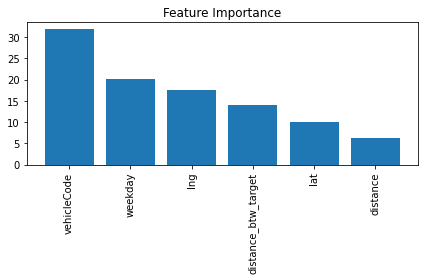

In [91]:
importances = model1.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(x_test.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(x_test.shape[1]), x_test.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [81]:
te= test_df.loc[set(target_df[target_df['vehicleCode']=='W44-2'].index) & set(test_df.index)]
te

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


,vehicleCode,lat,lng,distance,distance_btw_target,weekday,left_time,pred
14942214,W44-2,35.046275,136.933360,123.618314,262.473238,5,412.0,387.084435
15073297,W44-2,35.343484,139.202953,105.173591,54.341707,1,57.0,72.544758
14942226,W44-2,35.048489,136.946084,101.098000,261.289064,5,411.0,357.351738
15073301,W44-2,35.347102,139.204213,104.743695,54.103840,1,57.0,79.040551
14942233,W44-2,35.045694,136.953419,124.992747,260.700284,5,410.0,370.910456
...,...,...,...,...,...,...,...,...
15073264,W44-2,35.340196,139.166892,101.727117,57.557914,1,60.0,82.336066
15073266,W44-2,35.340111,139.169114,101.083423,57.369563,1,60.0,84.389209
15073267,W44-2,35.339978,139.170215,101.172559,57.279458,1,60.0,84.389209
15073273,W44-2,35.338398,139.176812,105.537820,56.768269,1,59.0,74.136012


In [83]:
te.reset_index().sort_values(by='index')

,index,vehicleCode,lat,lng,distance,distance_btw_target,weekday,left_time,pred
32358,14353512,W44-2,35.315089,138.965334,26.119465,75.855881,5,125.0,120.100576
32360,14353516,W44-2,35.315560,138.966527,46.473321,75.737374,5,125.0,98.942901
32366,14353529,W44-2,35.325547,138.972369,103.742825,74.926731,5,124.0,120.690985
32374,14353535,W44-2,35.331167,138.971931,105.331105,74.802262,5,123.0,95.915531
32375,14353536,W44-2,35.332130,138.971944,106.848171,74.773716,5,123.0,100.166059
...,...,...,...,...,...,...,...,...,...
40104,15153560,W44-2,35.496327,139.765295,78.601711,0.720640,5,1.0,5.154933
40107,15153563,W44-2,35.497128,139.767117,55.711235,0.548129,5,1.0,-0.137484
40116,15153572,W44-2,35.499014,139.771425,31.068156,0.250745,5,0.0,20.426260
40118,15153573,W44-2,35.499078,139.771557,13.923211,0.247920,5,0.0,18.299796


## 창고

In [ ]:
target_df['velocity'] = target_df['distance']/target_df['del_time']

In [ ]:
target_df['weekday'] = target_df['timestamp'].dt.weekday
target_df['five_sec'] = target_df['timestamp'].dt.round('5s').dt.time
target_df['five_sec'] = target_df['five_sec'].apply(lambda x: x.strftime("%H:%M:%S"))
target_df = target_df.fillna(0)
target_df.loc[target_df['velocity']==np.inf, 'velocity'] = 0

In [ ]:
a = pd.DataFrame(target_df.groupby('five_sec')['velocity'].mean())
a.rename(columns = {'velocity':'velocity_mean_5sec'},inplace=True)
b = pd.DataFrame(target_df.groupby('five_sec')['velocity'].std())
b.rename(columns = {'velocity':'velocity_std_5sec'},inplace=True)
df1=pd.concat([a,b],axis=1).reset_index()

In [ ]:
c = pd.DataFrame(target_df.groupby('weekday')['velocity'].mean())
c.rename(columns = {'velocity':'velocity_mean_weekday'},inplace=True)
d = pd.DataFrame(target_df.groupby('weekday')['velocity'].std())
d.rename(columns = {'velocity':'velocity_std_weekday'},inplace=True)
df2=pd.concat([c,d],axis=1).reset_index()

In [ ]:
target_df = pd.merge(target_df, df1, on='five_sec', how='left')
target_df = pd.merge(target_df, df2, on='weekday', how='left')

In [ ]:
# vehicleCode별로 코스의 총거리 평균
e = pd.DataFrame(target_df.groupby(["vehicleCode","course"]).distance.sum().reset_index().groupby('vehicleCode').distance.mean())
e.rename(columns = {'distance':'total_distance_mean_vehicle'},inplace=True)
# vehicleCode별로 코스의 총시간 평균
f = pd.DataFrame(target_df.groupby(["vehicleCode","course"]).del_time.sum().reset_index().groupby('vehicleCode').del_time.mean())
f.rename(columns = {'del_time':'total_time_mean_vehicle'},inplace=True)
df3=pd.concat([e,f],axis=1).reset_index()

In [ ]:
target_df = pd.merge(target_df, df3, on='vehicleCode', how='left')

In [ ]:
#df1.to_csv('../data/constant_velocity_5sec.csv',index=False)
#df2.to_csv('../data/constant_velocity_weekday.csv',index=False)
#df3.to_csv('../data/constant_total_distance_time.csv',index=False, encoding='shift_jis')

In [ ]:
#accumulative distance per course
target_df['cum_sum_distance'] = target_df.groupby("course").distance.cumsum()

#total distance per course
total_distance = target_df.groupby("course").distance.sum()

# mapping target_df with total distance per course
target_df['total_distance']= target_df.course.apply(lambda x : total_distance[x])

# left_distance per course
target_df['left_distance'] = target_df['total_distance'] - target_df['cum_sum_distance']

In [ ]:
#accumulative time per course
target_df['cum_sum_time'] = target_df.groupby("course").del_time.cumsum()

#total time_consumption per course
total_time = target_df.groupby("course").del_time.sum()

# mapping target_df with total tite_consumption per course
target_df['total_time']= target_df.course.apply(lambda x : total_time[x])

# left_time per course
target_df['left_time'] = target_df['total_time'] - target_df['cum_sum_time']

In [ ]:
target_df['start']=target_df['is_in_target']
target_df['end']=target_df['is_in_target']
target_df['start'].replace(0, np.NaN,inplace=True)
target_df['end'].replace(0, np.NaN,inplace=True)

courses=target_df['course'].unique()
courses.sort()


idx=[]
for i in courses:
    idx.append(target_df[target_df['course']==i].index[0])
target_df.loc[idx, 'start'] = 0
target_df.loc[idx, 'end'] = 0


if np.isnan(target_df['end'].iloc[-1]):
    target_df['end'].iloc[-1]=0
target_df['start'].fillna(method='ffill', inplace=True)
target_df['end'].fillna(method='bfill', inplace=True)

target_df['route_name']=target_df['start'].astype('int').astype('str')+target_df['end'].astype('int').astype('str')+target_df['vehicleCode']

In [ ]:
target_df.info()

In [ ]:
target_df.head()

In [ ]:
target_df.to_csv('../data/1208_preprocessed_dataset.csv',index=False, encoding='shift_jis')

## Modeling

In [ ]:
#import preprocessed_Dataset
data = pd.read_csv("1208_preprocessed_dataset.csv", encoding='shift_jis')
data.head()

In [ ]:
data.columns

In [ ]:
# in our model, only certain feature will be used (below features)
final_data=data[['vehicleCode', 'lat', 'lng', 'velocity', 'distance', 'is_in_target','course','total_distance_mean_vehicle','left_distance', 'cum_sum_time', 'total_time','route_name','weekday', 'velocity_mean_5sec', 'velocity_std_5sec','velocity_mean_weekday', 'velocity_std_weekday','left_time']]

In [ ]:
# make y value into minutes scale
final_data['left_time'] = final_data['left_time'].apply(lambda x : int(x/60))
final_data

### For making model more precisely, select validated course data

- By using IQR, delete the course that has too less timestamp
- Only course that passing through 4 of target place will be considered

In [ ]:
s = pd.DataFrame(data.groupby("course")['is_in_target'])
not_pass_target = []
for i in range(len(s)):
    if(s.iloc[i][1].sum()==0):
        not_pass_target.append(i+1)

In [ ]:
len(not_pass_target)

In [ ]:
final_data = final_data[~final_data['course'].isin(not_pass_target)]
final_data.head()

In [ ]:
temp = pd.DataFrame(final_data.groupby(['vehicleCode','course']).count())

Q1 = temp.groupby("vehicleCode")['lat'].describe()["25%"]
Q3 = temp.groupby("vehicleCode")['lat'].describe()["75%"]
IQR = Q3-Q1
min_limit = Q1-1.5*IQR
min_limit_dic = {}

for _,b in enumerate(min_limit.items()):
    min_limit_dic[b[0]] =b[1]

In [ ]:
min_limit_dic

In [ ]:
s = final_data.groupby(['vehicleCode',"course"])['vehicleCode'].count()
not_used = []
for key in min_limit_dic.keys():
    for _,i in enumerate(s[key].items()):        
        if(i[1]<min_limit_dic[key]):
            not_used.append(i[0])
len(not_used)

In [ ]:
selected_data = final_data[~final_data['course'].isin(not_used)]
selected_data

In [ ]:
selected_data = selected_data.drop('course',axis=1)

### train, test split

- split the dataset into (train, test) with course-wise by vehicleCode


In [ ]:
import random
temp = pd.DataFrame(selected_data.groupby("vehicleCode").course)
random.seed =1
test_course = []
for i in range(len(temp)):
    t = temp[1][i].values
    set_t = set(t)
    idx = random.sample(set_t,int(len(set_t)/8))
    set_t = list(set_t)
    test_course.extend(idx)
    

In [ ]:
test_data = selected_data[selected_data['course'].isin(test_course)]
train_data = selected_data[~selected_data['course'].isin(test_course)]
print("train_data len is {}".format(len(train_data)))
print("test_data len is {}".format(len(test_data)))

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
seed =1422
model1= CatBoostRegressor(
                          eval_metric = 'RMSE',
                          cat_features = ['vehicleCode','route_name','is_in_target','weekday'],
                          random_state=seed,
                         verbose = True)

X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

model1.fit(X_train , y_train)

In [ ]:
import pickle
# 파일명
filename = 'final_model_insight.model'

# 모델 저장
pickle.dump(model1, open(filename, 'wb'))

In [ ]:
# check the performance

from sklearn.metrics import mean_squared_error, r2_score
pred = model1.predict(X_test)
mse = mean_squared_error(y_test , pred)
r2 = r2_score(y_test, pred)
print(f'rmse : {np.sqrt(mse)}')
print(f'r2 : {r2}')

In [ ]:
# RMSE by VehicleCode

from tqdm import tqdm
vehicleCode = test_data['vehicleCode'].unique()
res = []
for vehicle in tqdm(vehicleCode):
    temp = test_data[test_data['vehicleCode']==vehicle]
    X_temp = temp.iloc[:, :-1]
    y_temp= temp.iloc[:, -1]
    pred = model1.predict(X_temp)
    mse = mean_squared_error(y_temp , pred)
    rmse = np.sqrt(mse)
    res.append(rmse)
    #r2 = r2_score(y_test, pred)
    print("vehicle code : {} , rmse : {}".format(vehicle, rmse))
    #print(f'r2 : {r2}')
    

In [ ]:
show = pd.DataFrame()
show['gt'] = y_test
show['pred'] = pred
show['dif'] = show['gt']-show['pred']
sns.kdeplot(show['dif'])


In [ ]:
t= test_data
t['gt'] = show['gt']
t['pred'] = show['pred']
t.head()

In [ ]:
#Except Exceptional vehicleCode
adjust_mse = mean_squared_error(t[~t['vehicleCode'].isin(['W47-2'])]['pred'],t[~t['vehicleCode'].isin(['W47-2'])]['gt'])
adjust_r2 = r2_score(y_test, pred)
print(f'rmse : {np.sqrt(adjust_mse)}')
print(f'r2 : {adjust_r2}')

### get insight from the modeling result

In [ ]:
pd.cut(show.dif,[show['dif'].min(),-60,-30,-10,0,10,30,60,show['dif'].max()]).value_counts()/len(show)*100

In [ ]:
show['dif'].hist(bins=150)

In [ ]:
sns.kdeplot(show['dif'])


In [ ]:
sns.scatterplot(show.index, show['dif'])

In [ ]:
explainer_1 = shap.Explainer(model1)
shap_values = explainer_1(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=10)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type='bar',max_display = 10)

In [ ]:
k = pd.DataFrame(columns = ['vehicleCode', 'lat', 'lng', 'velocity', 'distance', 'is_in_target','total_distance_mean_vehicle','left_distance', 'cum_sum_time', 'total_time','route_name','weekday', 'velocity_mean_5sec', 'velocity_std_5sec','velocity_mean_weekday', 'velocity_std_weekday'])


k

In [ ]:
k.shape

In [ ]:
importances = model1.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(k.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(k.shape[1]), k.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
def show_temp(c):
    
    fig, ax1 = plt.subplots()
    n = t[t['course']==c]
    print(len(n))
    ax1 = sns.scatterplot(n.index,n['pred'], color = 'r', s= 2)
    ax1.plot
    ax2= ax1.twinx()
    ax2 = sns.scatterplot(n.index,n['gt'], s =2)
    plt.title("gt vs ourmodel")
